In [2]:
import xarray as xr
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time
import glob
import json
import os
import torch

from sklearn.utils import shuffle 

import src

### Loading and processing PV
<a id='loading_pv'></a>

In [3]:
pv_metadata_df = src.data.load_pv.load_pv_metadata("~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_METADATA_FILEPATH)

In [5]:
pv_power_df = src.data.load_pv.load_pv_power(filepath="~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_DATA_FILEPATH, 
                                             start='2018-01-01', end='2019-12-31')

In [6]:
pv_power_df = pv_power_df.dropna(axis=0, how='all')

In [8]:
# Drop systems (in-place) without PV data and metadata
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [9]:
# make clearsky GHI object
latitude, longitude = pv_metadata_df.loc[pv_power_df.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude, g0=10)

# filter data to daylight hours (in-place)
ghiscalar.filter_to_daylight(pv_power_df, min_ghi=20, inplace=True)

In [10]:
# drop systems with no daylight
pv_power_df = pv_power_df.dropna(axis=0, how='all')
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [11]:
# scale by max power output
rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_df = rminmax.fit_transform(pv_power_df)

For the satellite and NWP data we will set the loaders to take more than we want. This means we can subset from this for the different networks we train.

### Choosing NWP channels to load
<a id='nwp_channels'></a>

In [12]:
src.data.nwp_loader.AVAILABLE_CHANNELS

,description
channel_name,
t,1.5m air temperature at surface
r,1.5m Relative humidity
dpt,1.5m dew point temperature
vis,1.5m visibility
si10,10m wind speed
wdir10,10m wind direction
prmsl,Mean sea level pressure
unknown_1,Uncertain. This is likely '1.5m fog probability'
unknown_2,Uncertain. This is likely 'snow fraction'


In [13]:
nwp_channels = ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf', 'si10', 'wdir10']

In [14]:
# set up NWP loader with some obvious seeming channels (this takes a minute or two)
nwploader = src.data.nwp_loader.NWPLoader(height=144000, width=144000, channels=nwp_channels)

### Choosing sat channels to load
<a id='sat_channels'></a>

In [15]:
pd.set_option('display.max_colwidth', 150)
src.data.sat_loader.AVAILABLE_CHANNELS

,description
channel_name,
VIS006,"λ_central=0.635µm, λ_min=0.56µm, λ_max=0.71µm, | Main observational purposes : Surface, clouds, wind fields"
VIS008,"λ_central=0.81µm, λ_min=0.74µm, λ_max=0.88µm, | Main observational purposes : Surface, clouds, wind fields"
IR_016,"λ_central=1.64µm, λ_min=1.50µm, λ_max=1.78µm, | Main observational purposes : Surface, cloud phase"
IR_039,"λ_central=3.90µm, λ_min=3.48µm, λ_max=4.36µm, | Main observational purposes : Surface, clouds, wind fields"
WV_062,"λ_central=6.25µm, λ_min=5.35µm, λ_max=7.15µm, | Main observational purposes : Water vapor, high level clouds, upper air analysis"
WV_073,"λ_central=7.35µm, λ_min=6.85µm, λ_max=7.85µm, | Main observational purposes : Water vapor, atmospheric instability, upper-level dynamics"
IR_087,"λ_central=8.70µm, λ_min=8.30µm, λ_max=9.1µm, | Main observational purposes : Surface, clouds, atmospheric instability"
IR_097,"λ_central=9.66µm, λ_min=9.38µm, λ_max=9.94µm, | Main observational purposes : Ozone"
IR_108,"λ_central=10.80µm, λ_min=9.80µm, λ_max=11.80µm, | Main observational purposes : Surface, clouds, wind fields, atmospheric instability"


In [16]:
sat_channels = src.data.sat_loader.DEFAULT_CHANNELS
sat_channels

['VIS006',
 'VIS008',
 'IR_016',
 'IR_039',
 'WV_062',
 'WV_073',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'HRV']

In [17]:
# set up sat loader with high resolutipon visual and a couple of infrared channels
satloader = src.data.sat_loader.SatelliteLoader(height=144000, width=144000, channels=sat_channels)

### Defining shuffle
<a id='define_shuffle'></a>

In [20]:
y_train_time, y_test_time = src.features.preprocessing.train_test_split_day(pv_prop_max_df, 0.2, shuffle=True, seed=4384321)

from sklearn.model_selection import train_test_split
train_columns, test_columns= train_test_split(pv_prop_max_df.columns, test_size=0.2, random_state=87695)

# different systems and different times
y_train = y_train_time.reindex(columns=train_columns, copy=False)
y_test_systemtime = y_test_time.reindex(columns=test_columns, copy=False)


y_meta_train = pv_metadata_df.reindex(y_train.columns, copy=False)
y_meta_test_systemtime = pv_metadata_df.reindex(y_test_systemtime.columns, copy=False)

In [21]:
y_meta_train = pv_metadata_df.reindex(y_train.columns, copy=False)

In [86]:
batch_generator = src.data.batch_loader.cross_processor_batch(
            y_train, 
            y_meta_train, 
            y_index_sequence=[0],
            max_missing_sequence_vals=0,
            sat_loader=satloader,
            nwp_loader=nwploader,
            include_tod=False,
            include_toy=False,
            include_latlon=False,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=256, 
            batches_per_superbatch=100, 
            n_superbatches=None, 
            n_epochs=1, 
            gpu=1,
            samples_per_datetime=100,
            parallel_loading_cores=2)

In [87]:
test_batch_generator = src.data.batch_loader.cross_processor_batch(
            y_test_systemtime, 
            y_meta_test_systemtime, 
            y_index_sequence=[0],
            max_missing_sequence_vals=0,
            sat_loader=satloader,
            nwp_loader=nwploader,
            include_tod=False,
            include_toy=False,
            include_latlon=False,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=1000, 
            batches_per_superbatch=1, 
            n_superbatches=1, 
            n_epochs=None, 
            gpu=1,
            samples_per_datetime=1,
            parallel_loading_cores=1)

In [76]:
%time test_batch = next(test_batch_generator)

CPU times: user 30min 24s, sys: 2min 25s, total: 32min 50s
Wall time: 24min 58s


### Defining network structure
<a id='network_factory'></a>

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch
from torchsummary import summary

In [25]:
def conv_out_size(w, padding, dilation, kernel_size, stride):
    return (w + 2*padding - dilation*(kernel_size -1) - 1)/stride + 1

In [101]:
class DNet(nn.Module):
    def __init__(
        self,
        image_side,
        conv_channels=[3,6,12],
        dense_units=[1],
        kernel_size=3,
        batch_norm=False,
        final_activation=None,
    ):
        """
        Args:
            image_side (int): size of side of square image,
            conv_channels (array_like, int):
            n_classes (int): number of output channels
            kernel_size (int): kernel size
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            final_activation (nn.Module)
        """
        super(DNet, self).__init__()
        assert kernel_size%2==1, 'please choose odd kernel size'

        # Construct backbone
        self.down_path = nn.ModuleList()

        # First convolution has no downscaling
        self.down_path.append(ConvBlock(conv_channels[0], conv_channels[1], kernel_size, batch_norm))

        # Downscaling convolutions
        for i in range(1, len(conv_channels)-1):
            self.down_path.append(
                DownConvBlock(conv_channels[i], conv_channels[i+1], kernel_size, batch_norm)
            )

        self.crop = CropPool(2)

        # calculate final conv layer image dimension
        img_final_side = image_side 
        for _ in range(len(conv_channels)-2):
            img_final_side = img_final_side// 2
        self.img_final_side = img_final_side
        self.image_side = image_side

        # construct final dense net
        dense_units = [img_final_side**2*sum(conv_channels[1:])] + dense_units
        self.fully_connected = FullyConnected(dense_units, batch_norm, final_activation)

    def forward(self, x):
        xs = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            for i in range(len(xs)):
                xs[i] = self.crop(xs[i])
            xs.append(x)

        xs = [torch.flatten(xi, start_dim=1) for xi in xs]
        x = torch.cat(xs, dim=1)
        return self.fully_connected(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, batch_norm):
        super(ConvBlock, self).__init__()
        block = []

        padding = kernel_size//2

        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_channels))

        block.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_channels))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class DownConvBlock(ConvBlock):
    def __init__(self, in_channels, out_channels, kernel_size, batch_norm):
        super(DownConvBlock, self).__init__(in_channels, out_channels, kernel_size, batch_norm)
        self.pool = nn.MaxPool2d(2, 2)#

    def forward(self, x):
        out = super(DownConvBlock, self).forward(x)
        return self.pool(out)


class CropPool(nn.Module):
    """Takes a centre crop of the image. `fraction` of size in each dimension"""
    def __init__(self, factor):
        super(CropPool, self).__init__()
        self.factor = factor

    def forward(self, x):
        _, _, height, width = x.size()
        new_height = height // self.factor
        new_width = width // self.factor
        ny_0 = (height - new_height)//2
        ny_1 = ny_0 + new_height
        nx_0 = (width - new_width)//2
        nx_1 = ny_0 + new_width
        return x[:, :, ny_0:ny_1, nx_0:nx_1]


class FullyConnected(nn.Module):
    """A sequence of fully connected layers"""
    def __init__(self, dense_units, batch_norm, final_activation=None):
        super(FullyConnected, self).__init__()

        block = []

        for i in range(len(dense_units)-2):
            block.append(nn.Linear(dense_units[i], dense_units[i+1]))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm1d(dense_units[i+1]))

        # treat last layer separately
        block.append(nn.Linear(dense_units[-2], dense_units[-1]))
        if final_activation is not None:
            block.append(final_activation)

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out



class CropDNet(DNet):
    def __init__(self,
        image_side,
        conv_channels=[3,6,12],
        dense_units=[1],
        kernel_size=3,
        batch_norm=False,
        final_activation=None):
        super(CropDNet, self).__init__(image_side, conv_channels, dense_units, 
                                   kernel_size, batch_norm, final_activation)
    
    def forward(self, x):
        L = self.image_side
        i0 = (x.shape[-1] - L)//2
        i1 = i0+L
        x = x[:,:,i0:i1,i0:i1]
        return super(CropDNet, self).forward(x)


    
    
class Net(CropDNet):
    def __init__(self, 
                 net_sat_channels, 
                 net_nwp_channels, 
                 conv_hidden_units,
                 image_side = 11,
                 kernel_size=3,
                 dense_units=[1], 
                 batch_norm=True,
                 final_activation=F.relu):
        
        self.config = dict(
                 net_sat_channels=net_sat_channels, 
                 net_nwp_channels=net_nwp_channels, 
                 conv_hidden_units=conv_hidden_units,
                 image_side=image_side,
                 kernel_size=kernel_size,
                 dense_units=dense_units, 
                 batch_norm=batch_norm,
                 final_activation=str(final_activation),
        )
        
        # save channel indexes
        self.sat_indexes = [i for i, channel in enumerate(sat_channels) if channel in net_sat_channels]
        self.nwp_indexes = [i for i, channel in enumerate(nwp_channels) if channel in net_nwp_channels]
        self.input_channels = len(self.sat_indexes)+len(self.nwp_indexes)
        assert self.input_channels > 0, 'must have satellite and/or nwp channels'
        
        conv_channels = [self.input_channels] + conv_hidden_units
        super(Net, self).__init__(image_side, conv_channels, dense_units, 
                                   kernel_size, batch_norm, final_activation)


    def forward(self, batch):
        
        if len(self.sat_indexes)>0 and len(self.nwp_indexes)>0:
            x = torch.cat((batch['satellite'][:,self.sat_indexes], batch['nwp'][:, self.nwp_indexes]), dim=1)
        elif len(self.sat_indexes)>0:
            x = batch['satellite'][:,self.sat_indexes]
        elif len(self.nwp_indexes)>0:
            x = batch['nwp'][:, self.nwp_indexes]
        
        return super(Net, self).forward(x)
    
    def summary(self):
        d = 'cuda' if next(self.parameters()).is_cuda else 'cpu'
        equivalent_model = CropDNet(
            self.config['image_side'], [self.input_channels] + self.config['conv_hidden_units'], 
            self.config['dense_units'],  self.config['kernel_size'], self.config['batch_norm']).to(d)
        return summary(equivalent_model, input_size=(self.input_channels, self.config['image_side'], self.config['image_side']))

Make example network to sheck structure

In [27]:
device='cuda'

model = Net(
        ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
        ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf', 'si10', 'wdir10'], 
        image_side=32,
        conv_hidden_units=[64, 32, 16, 8, 4, 2],
        kernel_size=3,
        dense_units=[10, 1],
        batch_norm=True,
        final_activation = nn.ReLU()
).to(device)

model.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          13,312
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         ConvBlock-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]          18,464
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,248
              ReLU-9           [-1, 32, 32, 32]               0
        MaxPool2d-10           [-1, 32, 16, 16]               0
    DownConvBlock-11           [-1, 32, 16, 16]               0
         CropPool-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]           4,624
             ReLU-14           [-1, 16,

In [28]:
%time test_batch = next(test_batch_generator)

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/opt/conda/envs/manual_pv/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/manual_pv/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/davidjamesfulton93/repos/predict_pv_yield/src/data/batch_loader.py", line 590, in single_thread_data_gather
    dt.floor('5min') - pd.Timedelta('1min'), *xy
  File "/home/davidjamesfulton93/repos/predict_pv_yield/src/data/sat_loader.py", line 215, in get_rectangle_array
    ds = self.get_rectangle(time, centre_x, centre_y)
  File "/home/davidjamesfulton93/repos/predict_pv_yield/src/data/sat_loader.py", line 187, in get_rectangle
    self._cache = self.dataset.sel(time=times).load()
  File "/opt/conda/envs/manual_pv/lib/python3.7/site-packages/xarray/core/dataset.py", line 2102, in sel
    self, indexers=indexers, method=method, tolerance=tolerance
  File "/opt/conda/envs/manual

CPU times: user 15min 25s, sys: 1min 20s, total: 16min 45s
Wall time: 17min 18s


In [78]:
test_batch = {k:v[...,0] if k!='y' else v for k,v in test_batch.items()}

In [79]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:             51          23          23           0           4          27
Swap:             0           0           0


In [102]:
from torch.cuda.amp import GradScaler, autocast

In [103]:
STATS_PERIOD = 100 # batch_generator.batches_per_superbatch
MSE_LOSS_FUNC = nn.MSELoss()
MAE_LOSS_FUNC = nn.L1Loss()
MODEL_DUMP_ROOT = os.path.expanduser('~/model_dump/015')

class net_container_mp:
    def __init__(self, net, optimizer, loss_func=nn.MSELoss(), run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.scalar = GradScaler()
        self.loss_func = loss_func
        self.run_name = run_name
        
        self.running_train_loss = 0
        self.running_train_mse = 0
        self.running_train_mae = 0
        
        self.train_losses = []
        self.train_mse_losses = []
        self.train_mae_losses = []
        
        self.test_losses = []
        self.test_mse_losses = []
        self.test_mae_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, batch, batch_number):
        
        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        self.net.train()
        
        with autocast():
            outputs = self.net(batch)
            train_loss = self.loss_func(outputs, batch['y'])
            
        self.running_train_loss += train_loss.item()
        self.scalar.scale(train_loss).backward()
        self.scalar.step(self.optimizer)
        self.scalar.update()
        
        # MAE
        train_mae = MAE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mae += train_mae.item()
        
        # MSE
        train_mse = MSE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mse += train_mse.item()

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                mean_train_mse = self.running_train_mse
                mean_train_mae = self.running_train_mae
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD
                mean_train_mse = self.running_train_mse / STATS_PERIOD
                mean_train_mae = self.running_train_mae / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            self.train_mse_losses.append(mean_train_mse)
            self.train_mae_losses.append(mean_train_mae)
            
            self.running_train_loss = 0.
            self.running_train_mse = 0.
            self.running_train_mae = 0.

            # Test loss
            self.net.eval()
            with autocast():
                test_outputs = self.net(test_batch)
                test_loss = self.loss_func(test_outputs, test_batch['y']).item()
                test_mae = MAE_LOSS_FUNC(test_outputs, test_batch['y']).item()
                test_mse = MSE_LOSS_FUNC(test_outputs, test_batch['y']).item()
                
            self.test_losses.append(test_loss)
            self.test_mae_losses.append(test_mae)
            self.test_mse_losses.append(test_mse)
            
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(os.path.join(thisdir, "figures"))
                    
                    with open(os.path.join(thisdir, 'config.json'), 'w') as f:
                        json.dump(self.net.config, f, indent=4)
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'train_mse':self.train_mse_losses,
                    'train_mae':self.train_mae_losses,
                    'test_loss':self.test_losses,
                    'test_mse':self.test_mse_losses,
                    'test_mae':self.test_mae_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))
                    

In [109]:
device='cuda'

model1 = Net(
        ['IR_016','IR_039','WV_062','IR_087','IR_108','IR_134','HRV'],
        ['t', 'r', 'prmsl', 'lcc', 'mcc', 'hcc', 'dswrf'], 
        image_side=16,
        conv_hidden_units=[64, 32, 16, 8, 4],
        kernel_size=5,
        dense_units=[10, 1],
        batch_norm=True,
        final_activation = nn.ReLU()
).to(device)


model2 = Net(
        ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
        ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf', 'si10', 'wdir10'], 
        image_side=16,
        conv_hidden_units=[64, 32, 16, 8, 4],
        kernel_size=5,
        dense_units=[10, 1],
        batch_norm=True,
        final_activation = nn.ReLU()
).to(device)

In [116]:
model3 = Net(
        ['IR_016','IR_039','WV_062','IR_087','IR_108','IR_134','HRV'],
        ['t', 'r', 'prmsl', 'lcc', 'mcc', 'hcc', 'dswrf'], 
        image_side=32,
        conv_hidden_units=[64, 32, 16, 8, 4, 2],
        kernel_size=5,
        dense_units=[10, 1],
        batch_norm=True,
        final_activation = nn.ReLU()
).to(device)

model4 = Net(
        ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
        ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf', 'si10', 'wdir10'], 
        image_side=32,
        conv_hidden_units=[64, 32, 16, 8, 4, 2],
        kernel_size=5,
        dense_units=[10, 1],
        batch_norm=True,
        final_activation = nn.ReLU()
).to(device)

In [117]:
def training_container_mp(model, name):
    return net_container_mp(
        model,
        optimizer=optim.Adam(model.parameters(), lr=0.0001), 
        loss_func=nn.MSELoss(),
        run_name=name,
    )

mixed_precision_containers = []
for net, name in [
                  (model1, 'less_channels_mp16_2'),
                  (model2, 'more_channels_mp16_2'),
                  (model3, 'less_channels_mp32_2'),
                  (model4, 'more_channels_mp32_2'),
                 ]:
    mixed_precision_containers.append(training_container_mp(net, name))

In [118]:
test_batch = {k:v.float() for k, v in test_batch.items()}

In [119]:
STATS_PERIOD = 100

In [ ]:
shuffles_per_superbatch = 1
current_shuffles = 1

for i_batch, batch in enumerate(batch_generator):
    
    batch = {k:v[...,0] if k!='y' else v for k,v in batch.items()}
    batch = {k:v.float() for k,v in batch.items()}
    
    for container in mixed_precision_containers:
        print(f'batch:{i_batch:03} | {container.run_name:30s}\r', end="")
        container.train_step(batch, i_batch)
        
    # if we have got to end of superbatch reshuffle
    if batch_generator.batch_index==(batch_generator.batches_per_superbatch-1):
        # but only if we haven't already shuffled so mnay times
        if current_shuffles < shuffles_per_superbatch:
            batch_generator.shuffle_cpu_superbatch()
            if batch_generator.gpu==2: batch_generator.transfer_superbatch_to_gpu()
            batch_generator.batch_index = 0
            current_shuffles+=1
        # if we have shiuffled our limit of times then update shuffle tally
        elif current_shuffles >= shuffles_per_superbatch:
            print(f'batch:{i_batch} - reshuffled this super-batch too many times. Loading new.\r', end="")
            current_shuffles = 1


print('\nFinished Training')

In [121]:
test_pred = model2(test_batch)
pred = model2(batch)

In [125]:
MAE_LOSS_FUNC(test_pred, test_batch['y'])

tensor(0.1140, device='cuda:0', grad_fn=<L1LossBackward>)

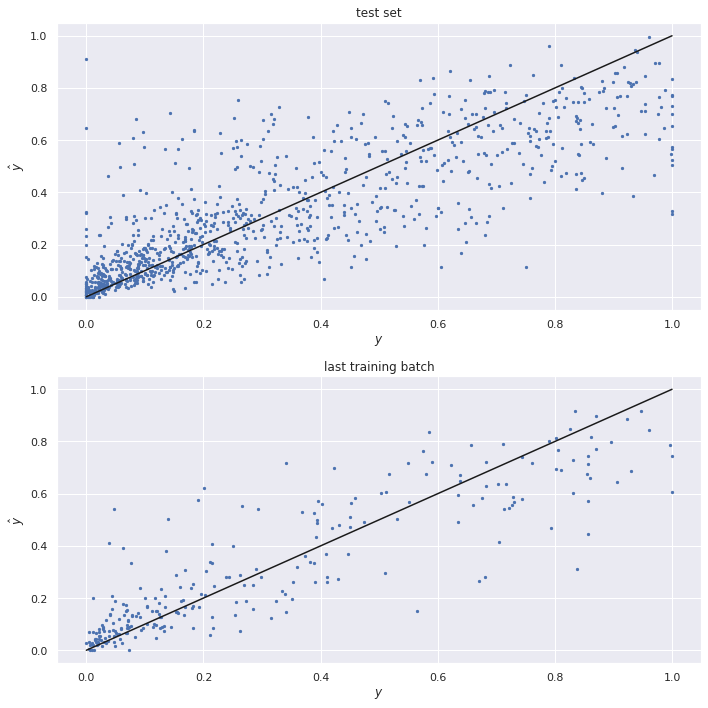

In [143]:
plt.figure(figsize=(10,10))

zero_one = np.array([0,1])

plt.subplot(2,1,1)
plt.title('test set')
plt.plot(zero_one, zero_one, color='k')
plt.scatter(test_batch['y'].detach().cpu().numpy(), test_pred.detach().cpu().numpy(), s=5)
plt.xlabel('$y$')
plt.ylabel('$\hat{y}$')


plt.subplot(2,1,2)
plt.title('last training batch')
plt.plot(zero_one, zero_one, color='k')
plt.scatter(batch['y'].detach().cpu().numpy(), pred.detach().cpu().numpy(), s=5)
plt.xlabel('$y$')
plt.ylabel('$\hat{y}$')

plt.tight_layout()
plt.show()

## Plot training graphs

In [135]:
modelroot = os.path.expanduser('~/model_dump/015')

model_dumps = [x.split('/')[-1] for x in glob.glob(f"{modelroot}/*") if not x.endswith('ipynb')]
model_dumps = [x for x in model_dumps if ('mp16_2' in x) or ('mp32_2' in x)]
model_dumps

['less_channels_mp32_2',
 'more_channels_mp16_2',
 'less_channels_mp16_2',
 'more_channels_mp32_2']

In [136]:
dfs = [pd.read_csv(f'{modelroot}/{model}/training_stats.csv', ).set_index('batch').dropna()\
       for model in model_dumps]

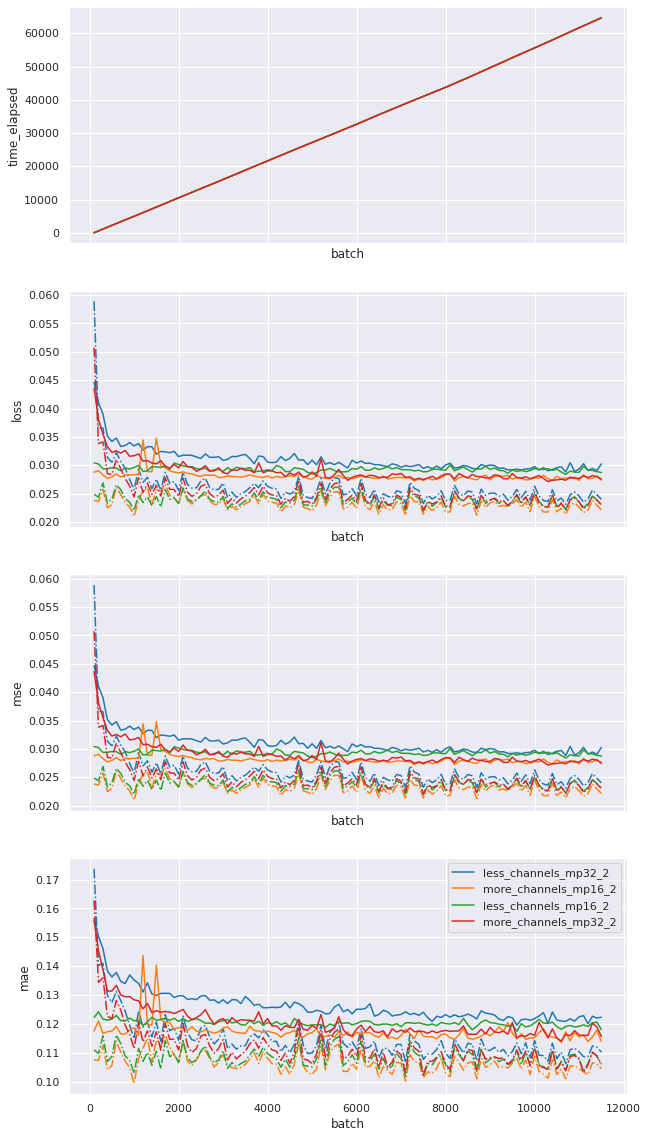

In [137]:
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
sns.set()


fig, axes = plt.subplots(4,1, sharex=True, figsize=(10,20))
axes = axes.flatten()
plot_metrics = ['time_elapsed', 'loss', 'mse', 'mae']

for ax, metric in zip(axes, plot_metrics):
    colors = cycle(prop_cycle.by_key()['color'])
    
    for i in range(len(model_dumps)):
        c = next(colors)
        df_ = dfs[i].iloc[1:]#.rolling(10).mean()#.iloc[:3]
        if metric=='time_elapsed':
            ax.plot(df_.index, df_[metric], label=model_dumps[i], color=c)
        else:
            ax.plot(df_.index, df_['train_'+metric], linestyle='-.', color=c)
            ax.plot(df_.index, df_['test_'+metric], linestyle='-', label=model_dumps[i], color=c)
    ax.set_xlabel('batch')
    ax.set_ylabel(metric)
ax.legend()
plt.show()

Note that in the training graphs I had actuall pretrained the mp16 models before this. Therefore they start off better

## Best results throughout training

In [140]:
final_results_df = {}
for i,model in enumerate(model_dumps):
    df = dfs[i].iloc[:].min()
    for ind in df.index:
        if ind in final_results_df.keys():
            final_results_df[ind].append(df[ind])
        else:
            final_results_df[ind] = [df[ind]]
pd.DataFrame(final_results_df, index=model_dumps).sort_values('test_loss')

,Unnamed: 0,time_elapsed,train_loss,train_mse,train_mae,test_loss,test_mse,test_mae
more_channels_mp32_2,0.0,0.075135,0.022073,0.022073,0.102357,0.027141,0.027141,0.114073
more_channels_mp16_2,0.0,0.032307,0.016862,0.016862,0.091568,0.027221,0.027221,0.113605
less_channels_mp16_2,0.0,0.027790,0.017353,0.017353,0.094141,0.028391,0.028391,0.117470
less_channels_mp32_2,0.0,0.070788,0.023093,0.023093,0.106294,0.028823,0.028823,0.119595
